In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *

import seaborn as sns
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

In [2]:
data1_path ="/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Option Biologie/genetique_network/data_train(2)/data1.csv"
target1_path = "/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Option Biologie/genetique_network/data_train(2)/target1.csv"
os.path.exists(target1_path)

True

# Exercice 3

## Question 1

Text(0.5, 1.0, 'Matrice de corrélation non signée ')

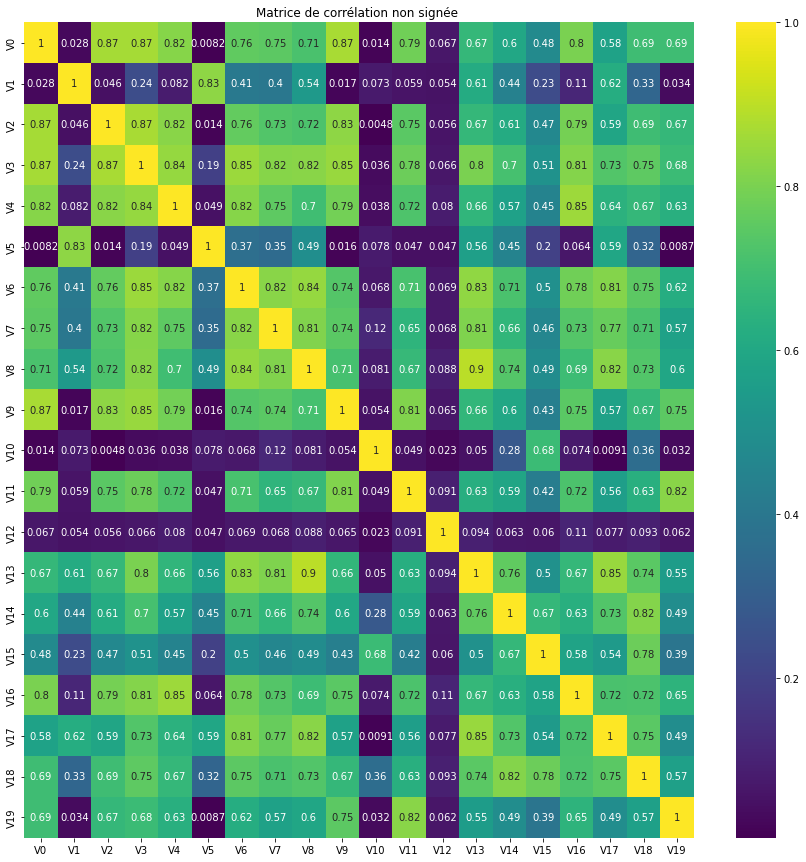

In [3]:
## Chargement des données et visualisation 
data = pd.read_csv(data1_path)
target = pd.read_csv(target1_path)
## Utiliser la fonction de l'exercice 1 pour remplacer les valeurs manquantes
data = replace_random_value(data)

matrix_corr = data.corr().abs()
plt.figure(figsize=(15,15))
sns.heatmap(matrix_corr,annot=True,cmap='viridis',cbar=false)
plt.title("Matrice de corrélation non signée ")

In [4]:
# Threshold Hard avec tau fixé

tau = 0.5
beta = 5

def WGCNA_threshold(tau,beta,matrix_corr):

    matrix_corr_copy = np.array(matrix_corr.copy())
    np.fill_diagonal(matrix_corr_copy,0) #permet de mettre des 0 sur la diagonale

    causal_matrix_tau = (matrix_corr_copy > tau).astype(np.int8) # créer un mask

    A_beta = matrix_corr_copy**beta #met à la puissance beta chaque valeur de la matrice

    return causal_matrix_tau, A_beta

causal_matrix_tau, A_beta = WGCNA_threshold(tau,beta,matrix_corr)



## Question 2

In [8]:
def WGCNA_TOM(tau,beta,matrix_corr):
    """Pour donner une notion de connectivité entre les gènes """
    A_beta = WGCNA_threshold(tau,beta,matrix_corr)[1]
    TOM_matrix = np.zeros(A_beta.shape)

    n = len(A_beta)
    for i in range(n):
        for j in range(i,n):
            I_ij = np.sum(A_beta[i,:]*A_beta[:,j])
            k_i = A_beta[i,:].sum()
            k_j = A_beta[:,j].sum()
            TOM_matrix[i,j] = (I_ij + A_beta[i,j])/(min(k_i,k_j) + 1 + A_beta[i,j])
            TOM_matrix[j,i] = TOM_matrix[i,j]
    return TOM_matrix


TOM_matrix = WGCNA_TOM(tau,beta,matrix_corr)


Text(0.5, 1.0, 'TOM_matrix')

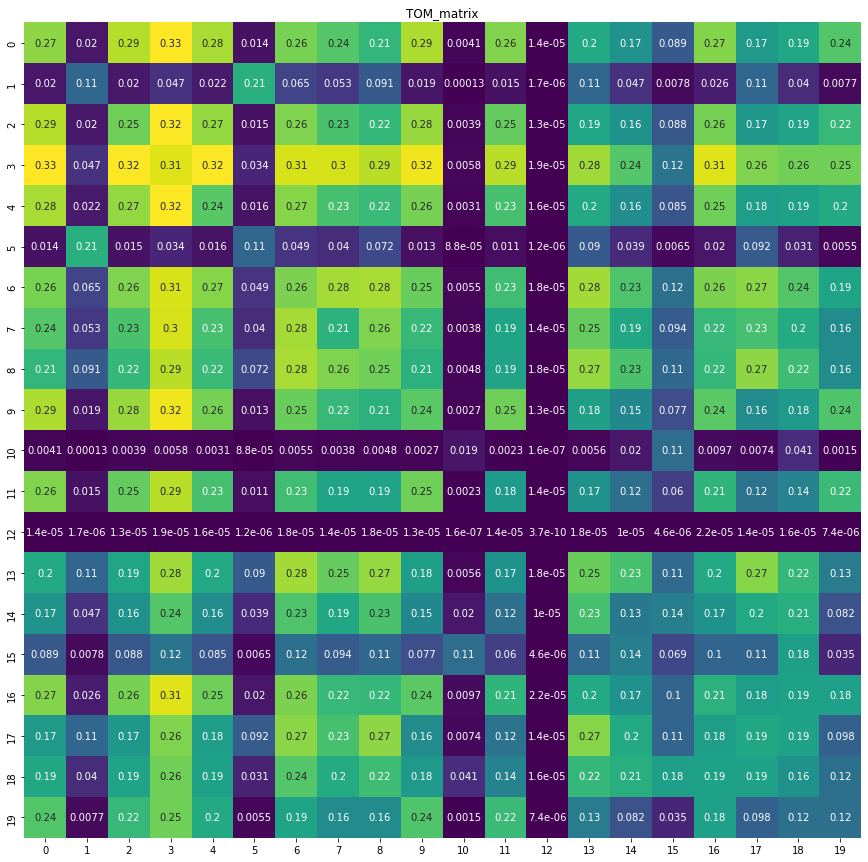

In [13]:


plt.figure(figsize=(15,15))
sns.heatmap(TOM_matrix,annot=True,cmap='viridis',cbar=False)
plt.title("TOM_matrix")

## Question 3 

In [14]:
from sklearn.cluster import AgglomerativeClustering

np.fill_diagonal(TOM_matrix,1)

# Définition du nombre de clusters souhaité
num_clusters = 8

# Appliquer la classification ascendante hiérarchique avec la matrice Distance
clustering = AgglomerativeClustering(n_clusters=num_clusters, metric='precomputed', linkage='average')
cluster_labels = clustering.fit_predict(TOM_matrix)

# Afficher les labels des clusters obtenus
print("Labels des clusters :", cluster_labels)

#Références :
#https://laeq.github.io/LivreMethoQuantBolR/sect133.html

Labels des clusters : [4 0 5 7 0 0 6 3 1 0 0 0 0 2 0 0 0 0 0 0]


## Question 4-5

In [17]:
from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(linkage='ward', compute_full_tree=True).fit(TOM_matrix)
ward

AgglomerativeClustering(compute_full_tree=True)

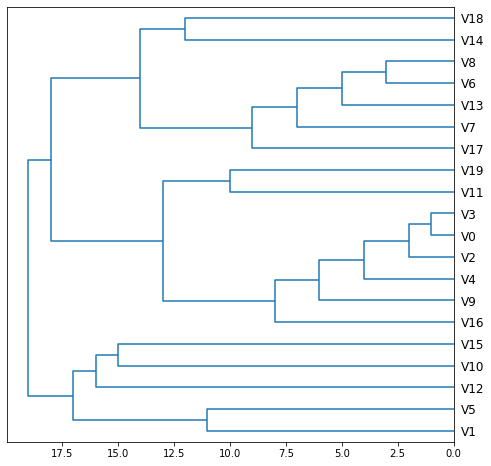

In [18]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

dendro = [ ]
for a,b in ward.children_:
    dendro.append([a, b, float(len(dendro)+1), len(dendro)+1])
    # le dernier coefficient devrait contenir le nombre de feuilles dépendant de ce noeud
    # et non le dernier indice
    # de même, le niveau (3ème colonne) ne devrait pas être le nombre de noeud
    # mais la distance de Ward

fig = plt.figure( figsize=(8,8) )
ax = fig.add_subplot(1,1,1)
r = dendrogram(dendro, color_threshold=1, labels=list(data.columns),
               show_leaf_counts=True, ax=ax, orientation="left")

In [20]:
target.sample(10)

,Cause,Effect
40,V11,V19
9,V1,V7
27,V5,V13
5,V0,V9
41,V13,V18
19,V3,V6
34,V8,V13
13,V2,V4
21,V4,V6
32,V6,V13


Au vu de l'arbre d'ascendance hiérarchique ci-dessus il n'est pas clair que la méthode WGCNA nous donne les bonnes relations entre les gènes. Il faudrait certainement modifier les paramètre 'alpha' et 'beta' pour voir si nous arrivons à un clustering plus satisfaisant. 

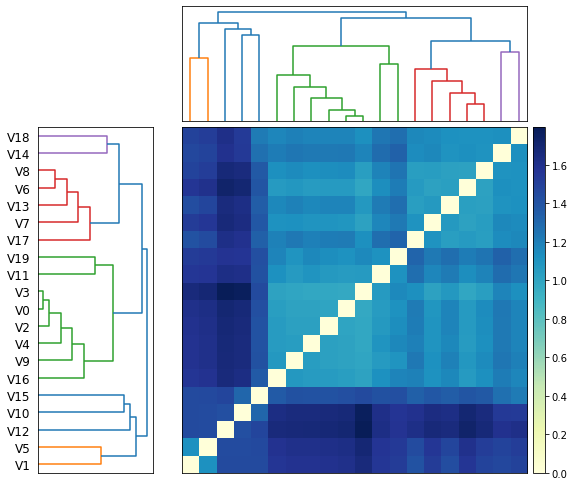

In [21]:
from scipy.spatial.distance import pdist, squareform



data_dist = pdist(TOM_matrix)

fig = plt.figure(figsize=(8,8))

# x ywidth height
ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
Z1 = dendrogram(dendro, orientation='right',labels=list(data.columns))
ax1.set_xticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z2 = dendrogram(dendro)
ax2.set_xticks([])
ax2.set_yticks([])

# Compute and plot the heatmap
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

D = squareform(data_dist)
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
plt.colorbar(im, cax=axcolor)

#Reférence : http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_correction_session_3A.html